In [1]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#PATH PROCESS
import os
from pathlib import Path
import glob
from scipy.io import loadmat


# image processing
import cv2
from scipy.ndimage import gaussian_filter

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np


# Exploring Dataset

Take one example to explore the structure of dataset

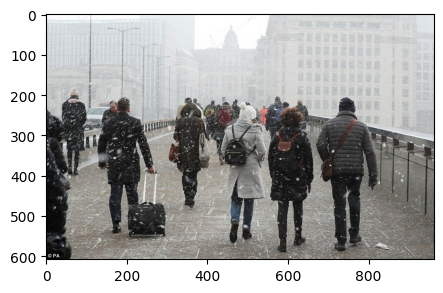

In [2]:
import cv2
path_img_ex = '/kaggle/input/mat-crowd/new_crowd/train/images/0025.jpg'
image_ex = cv2.cvtColor(cv2.imread(path_img_ex),cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(5,5))
plt.imshow(image_ex)
plt.show()

In [3]:
path_gt_ex = "/kaggle/input/mat-labels/labels/train/ground_truth/0025.mat"
gt_ex = loadmat(path_gt_ex)
print('type: ', type(gt_ex))
print(gt_ex.items())

type:  <class 'dict'>
dict_items([('__header__', b'MATLAB 5.0 MAT-file Platform: nt, Created on: Sat Aug 17 11:57:37 2024'), ('__version__', '1.0'), ('__globals__', []), ('image_info', array([[166., 228.],
       [414., 218.],
       [541., 232.],
       [353., 213.],
       [629., 222.],
       [497., 243.],
       [468., 222.],
       [448., 227.],
       [737., 220.],
       [188., 228.],
       [ 72., 198.],
       [371., 214.],
       [362., 242.],
       [606., 260.],
       [ 74., 228.],
       [597., 226.],
       [576., 213.]]))])


In [4]:
print(gt_ex.keys())

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])


In [5]:
gt_ex

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Sat Aug 17 11:57:37 2024',
 '__version__': '1.0',
 '__globals__': [],
 'image_info': array([[166., 228.],
        [414., 218.],
        [541., 232.],
        [353., 213.],
        [629., 222.],
        [497., 243.],
        [468., 222.],
        [448., 227.],
        [737., 220.],
        [188., 228.],
        [ 72., 198.],
        [371., 214.],
        [362., 242.],
        [606., 260.],
        [ 74., 228.],
        [597., 226.],
        [576., 213.]])}

In [6]:
gt_coor_ex = gt_ex.get('image_info')
print('Shape of coordinates: ', gt_coor_ex.shape)
#print(gt_coor_ex)


Shape of coordinates:  (17, 2)


The keyword 'image_info' gives the coordinates of location of each person in the image.

The shape[0] indicates the amount of people in the image.

Text(0.5, 1.0, 'Image and Coordinate')

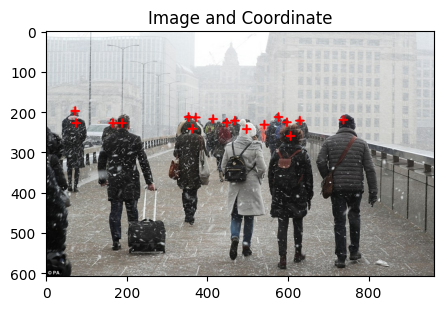

In [7]:
figure = plt.figure(figsize=(5,5))

for x_cor, y_cor in gt_coor_ex:
    cv2.drawMarker(image_ex, (int(x_cor), int(y_cor)),(255, 0, 0),thickness=3)

plt.imshow(image_ex)
plt.title("Image and Coordinate")

Extract the coordinate as density map. With the function *create_density_map*, the coordinate of people can be visulized, the sum of the density map is the amount of people in the image, the size of the density map is the same as the image.

The density map will be used as 'label' for neural network.

In [8]:
def gen_density_map_gaussian(image, coords, sigma=5):
    img_zeros = np.zeros((image.shape[:2]), dtype=np.float32)
    for x_cor, y_cor in coords:
        img_zeros[int(y_cor), int(x_cor)] = 1

    density_map = gaussian_filter(img_zeros,sigma=sigma,truncate=5*5)

    return density_map

max1 :  tensor(1.)
max2 :  0.006375769
min1 :  tensor(0.)
min2 :  0.0


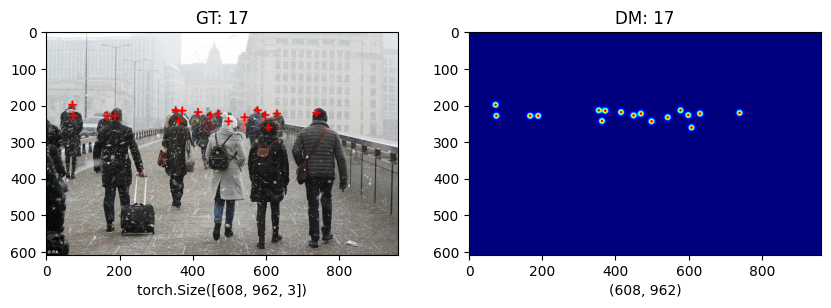

In [9]:
density_map_ex = gen_density_map_gaussian(image_ex, gt_coor_ex, 5)

figure = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
image_ex = torch.tensor(image_ex/255, dtype=torch.float)
plt.xlabel(image_ex.shape)
plt.title('GT: '+str(gt_coor_ex.shape[0]))
plt.imshow(image_ex)

plt.subplot(1,2,2)
plt.xlabel(density_map_ex.shape)
plt.title('DM: '+str(round(np.sum(density_map_ex))))
plt.imshow(density_map_ex, cmap="jet")

print('max1 : ', image_ex.max())
print('max2 : ', density_map_ex.max())
print('min1 : ', image_ex.min())
print('min2 : ', density_map_ex.min())

# Load Data

Create a data loader extract the key 'image_info' in MAT to obtain the coordinates of people location. Then use the *gen_density_map_gaussian* to create the density map of each image. In addition, take the dimension of the coordinate matrix as number of people, which can be used for model loss function. Downsample is applied in order to fit the shape of density map at output of training model.

In [10]:
import os
import random
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset
from scipy.io import loadmat
import torchvision.transforms as transforms

class DataLoader(Dataset):
    def __init__(self, root_dir, label_dir, transform=None, gt_downsample=4, shuffle=False):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.gt_downsample = gt_downsample
        self.shuffle = shuffle
        self.transform = transform

        self.img_names = [filename for filename in os.listdir(os.path.join(root_dir, 'images')) if filename.endswith('.jpg')]

        if self.shuffle:
            random.shuffle(self.img_names)

        self.n_people = {}
        self.DMs = {}
        for image_filename in self.img_names:
            img_path = os.path.join(root_dir, 'images', image_filename)
            GT_filename = image_filename[:-4] + '.mat'
            path_GT = os.path.join(label_dir, 'ground_truth', GT_filename)
            GT = loadmat(path_GT).get('image_info')
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            height, width = img.shape[:2]
            coords = [(x, y) for (x, y) in GT if 0 <= x < width and 0 <= y < height]
            self.DMs[img_path] = gen_density_map_gaussian(img, coords, 5)
            self.n_people[img_path] = GT.shape[0]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt_density_map = self.DMs[img_path]
        gt_n_people = self.n_people[img_path]

        if len(img.shape) == 2:  # expand grayscale image to three channels.
            img = img[:, :, np.newaxis]
            img = np.concatenate((img, img, img), 2)

        # Apply the transform to the image
        ds_rows = int(img.shape[0] // self.gt_downsample)
        ds_cols = int(img.shape[1] // self.gt_downsample)
        img = cv2.resize(img, (ds_cols*self.gt_downsample, ds_rows*self.gt_downsample))
        gt_density_map = cv2.resize(gt_density_map, (ds_cols, ds_rows))
        gt_density_map = gt_density_map[np.newaxis, :, :] * self.gt_downsample * self.gt_downsample

        img = img.transpose((2,0,1)) # convert to order (channel, rows, cols)
        img_tensor = torch.tensor(img/255, dtype=torch.float)
        dm_tensor = torch.tensor(gt_density_map, dtype=torch.float)

        return img_tensor, dm_tensor, gt_n_people





In [11]:
import os
import random
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset
from scipy.io import loadmat

class DataLoader(Dataset):
    def __init__(self, root_dir, label_dir, transform=None, target_size=(224, 224), shuffle=False):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.target_size = target_size  # Add target size as a parameter
        self.shuffle = shuffle
        self.transform = transform

        self.img_names = [filename for filename in os.listdir(os.path.join(root_dir, 'images')) if filename.endswith('.jpg')]

        if self.shuffle:
            random.shuffle(self.img_names)

        self.n_people = {}
        self.DMs = {}
        for image_filename in self.img_names:
            img_path = os.path.join(root_dir, 'images', image_filename)
            GT_filename = image_filename[:-4] + '.mat'
            path_GT = os.path.join(label_dir, 'ground_truth', GT_filename)
            GT = loadmat(path_GT).get('image_info')
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            height, width = img.shape[:2]
            coords = [(x, y) for (x, y) in GT if 0 <= x < width and 0 <= y < height]
            self.DMs[img_path] = gen_density_map_gaussian(img, coords, 5)
            self.n_people[img_path] = GT.shape[0]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt_density_map = self.DMs[img_path]
        gt_n_people = self.n_people[img_path]

        if len(img.shape) == 2:  # expand grayscale image to three channels.
            img = img[:, :, np.newaxis]
            img = np.concatenate((img, img, img), 2)

        # Resize the image to the target size
        img = cv2.resize(img, self.target_size)

        # Resize the density map to the target size while preserving the total sum
        orig_shape = gt_density_map.shape
        gt_density_map = cv2.resize(gt_density_map, self.target_size)
        scaling_factor = (orig_shape[0] / self.target_size[0]) * (orig_shape[1] / self.target_size[1])
        gt_density_map = gt_density_map * scaling_factor  # Adjust the density map by the scaling factor

        gt_density_map = gt_density_map[np.newaxis, :, :]  # add channel dimension

        img = img.transpose((2, 0, 1))  # convert to order (channel, rows, cols)
        img_tensor = torch.tensor(img / 255, dtype=torch.float)
        dm_tensor = torch.tensor(gt_density_map, dtype=torch.float)

        return img_tensor, dm_tensor, gt_n_people


In [12]:
root_dir = "/kaggle/input/mat-crowd/new_crowd/test/"
label_dir='/kaggle/input/mat-labels/labels/test/'
dataset = DataLoader(root_dir,label_dir, shuffle=True)


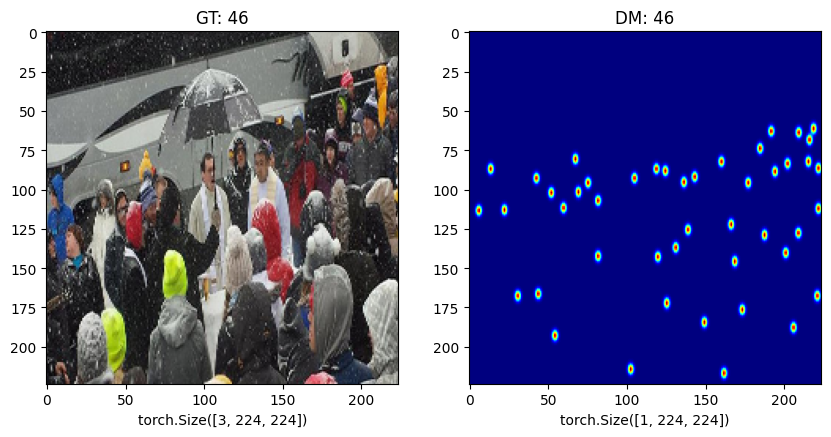

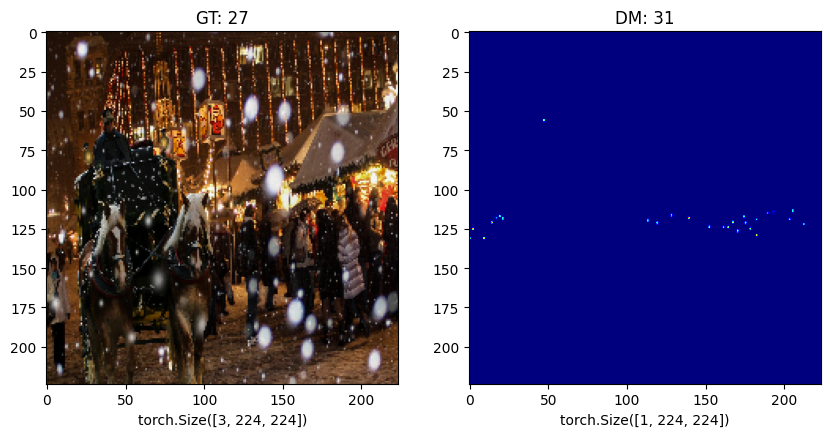

In [13]:
for i, (img, gt_dmap, n_people) in enumerate(dataset):
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.xlabel(img.shape)
  plt.title('GT: ' + str(n_people))
  #img=torch.from_numpy(img)  
  plt.imshow(img.permute(1, 2, 0))

  plt.subplot(1,2,2)
  plt.xlabel(gt_dmap.shape)
  plt.title('DM: ' + str(round(np.sum(gt_dmap.numpy()))))
  plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
  plt.show()

  if i > 0:
    #print('type of img: ', type(img))
    #print('type of dmap: ', type(gt_dmap))
    #print('shape of img: ', img.shape)
    break


In [14]:
batch_size = 8
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
import torchvision.transforms as transforms
train_root_dir = "/kaggle/input/mat-crowd/new_crowd/train/"
test_label_dir='/kaggle/input/mat-labels/labels/train/'
train_dataset = DataLoader(train_root_dir,test_label_dir,shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_root_dir = "/kaggle/input/mat-crowd/new_crowd/val/"
val_label_dir='/kaggle/input/mat-labels/labels/val/'
val_dataset = DataLoader(val_root_dir,val_label_dir, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_root_dir = "/kaggle/input/mat-crowd/new_crowd/test/"
test_label_dir='/kaggle/input/mat-labels/labels/test/'
test_set = DataLoader(test_root_dir,test_label_dir,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of batches in test_loader:", len(test_loader))

Number of batches in train_loader: 95
Number of batches in val_loader: 40
Number of batches in test_loader: 56


Print some samples of dataset as a sanity check

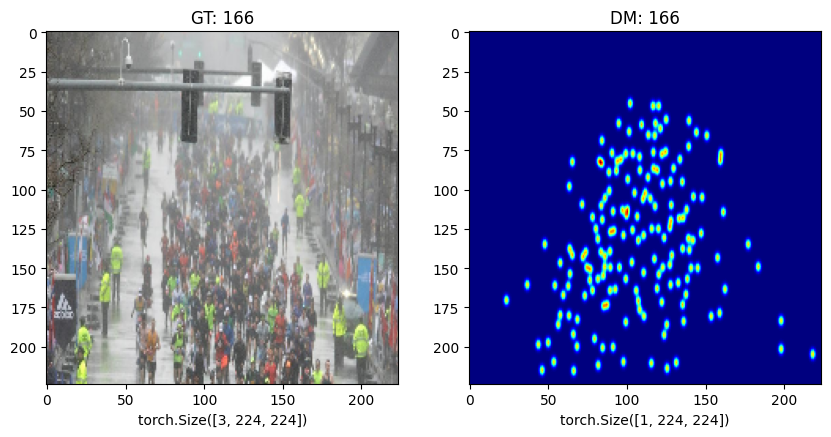

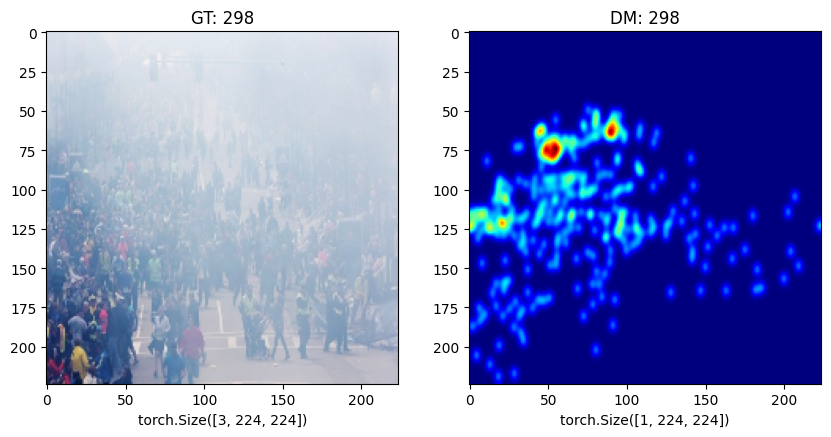

In [15]:
for i, (img, gt_dmap, n_people) in enumerate(train_dataset):
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.xlabel(img.shape)
  plt.title('GT: ' + str(n_people))
  #img=torch.from_numpy(img)  
  plt.imshow(img.permute(1, 2, 0))

  plt.subplot(1,2,2)
  plt.xlabel(gt_dmap.shape)
  plt.title('DM: ' + str(round(np.sum(gt_dmap.numpy()))))
  plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
  plt.show()

  if i > 0:
    #print('type of img: ', type(img))
    #print('type of dmap: ', type(gt_dmap))
    #print('shape of img: ', img.shape)
    break


# Create Model for Neural Network

Build a multi-column convolutional neural network for density map prediction.

The multi-column CNN consists of multiple parallel CNN columns, each processing the input data independently and at different resolutions. In the proposed architecture, the 1st column is with lowest resolution (with largest kernel size), and lowest depth; 2nd column has incresing resolution (smaller kernel size), and larger depth, and so on.

Each CNN column learns to extract features that contains different aspects from the input data. After feature extraction, the outputs from the all CNN columns are combined by concatenation. The combined features are passed through a single convolutional layer to generate the final output.

In [16]:
import torch
import torch.nn as nn

class MC_CNN(nn.Module):
    def __init__(self, input_size=224):
        super().__init__()

        self.column1 = nn.Sequential(
            nn.Conv2d(3, 8, 9, padding=4),  # same padding for 9x9
            nn.ReLU(),
            nn.Conv2d(8, 16, 7, padding=3),  # same padding for 7x7
            nn.ReLU(),
            nn.Conv2d(16, 32, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(32, 16, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding=3),
            nn.ReLU(),
        )

        self.column2 = nn.Sequential(
            nn.Conv2d(3, 10, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(10, 20, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(20, 40, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(40, 20, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(20, 10, 5, padding=2),
            nn.ReLU(),
        )

        self.column3 = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 24, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding=1),
            nn.ReLU(),
        )
        
        # Fusion layer to combine outputs of columns
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1, padding=0),  # Combining the feature maps from 3 columns
        )
        
        # Optional upsampling to match input size
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

    def forward(self, img_tensor):
        x1 = self.column1(img_tensor)  # (Batch, 8, 224, 224)
        x2 = self.column2(img_tensor)  # (Batch, 10, 224, 224)
        x3 = self.column3(img_tensor)  # (Batch, 12, 224, 224)

        # Concatenate along the channel dimension
        x = torch.cat((x1, x2, x3), 1)  # (Batch, 30, 224, 224)

        # Apply fusion layer
        x = self.fusion_layer(x)  # (Batch, 1, 224, 224)
        
        return x

# Example usage:
model = MC_CNN(input_size=224)
input_tensor = torch.randn(1, 3, 224, 224)  # Batch size of 1
output = model(input_tensor)
print(output.shape)  # Should output (Batch, 1, 224, 224)


torch.Size([1, 1, 224, 224])


In [17]:
img=torch.rand((1,3,768,1024),dtype=torch.float)
mcnn=MC_CNN()
out_dmap=mcnn(img)
print(out_dmap.shape)

torch.Size([1, 1, 768, 1024])


# Prepare the data for traning, validation, and testing

In [18]:
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    num_images = batch1.shape[0] # can change to 4 if for entire data set

    fig, axes = plt.subplots(int(np.ceil(num_images/2)), 4)

    for i in range(num_images):
        axes[int(i/4)*2, i%4].imshow(batch1[i].permute(1, 2, 0))
        axes[int(i/4)*2, i%4].axis('off')

        axes[int(i/4)*2+1, i%4].imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        axes[int(i/4)*2+1, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].set_title('DM: ' + str(round(np.sum(batch2[i].detach().numpy()))))

    plt.tight_layout()
    plt.show()

Print some samples of dataset as a sanity check

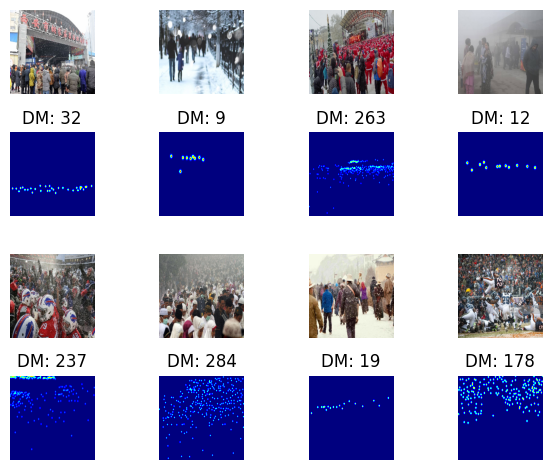

   32     9   263    12   237   284    19   178


In [19]:
dataiter = iter(test_loader)
ex_images, ex_dmaps, ex_n_people = next(dataiter)


# Show images and density map
plot_corresponding_pairs(ex_images, ex_dmaps)

# Print Ground truth number of people
print(' '.join('%5s' % ex_n_people[j].item() for j in range(batch_size)))

# Training Phase

Define a cost function that considering 
* Difference between density map and predicted image
* Difference between sum of predicted image (refering number of people) and the ground truth number of people

In [26]:
import torch
import torch.nn as nn
import torchmetrics.functional as tmf

class CombinedLoss(nn.Module):
    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2, max_pixel_value=1.0):
        super().__init__()
        self.weight_dmap = weight_dmap
        self.weight_sum_gt = weight_sum_gt
        self.img_loss = nn.MSELoss()
        self.gt_loss_mse = nn.MSELoss()
        self.gt_loss_mae = nn.L1Loss()
        self.max_pixel_value = max_pixel_value  # Maximum pixel value for PSNR

    def forward(self, logits, batch_dmap, batch_gts):
        batch_gts = batch_gts.float()

        # Calculate individual losses
        img_loss = self.img_loss(logits, batch_dmap)
        gt_loss_mae = self.gt_loss_mae(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)
        gt_loss_mse = self.gt_loss_mse(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)
        
        # Combine losses
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae

        # Calculate PSNR
        mse = torch.mean((logits - batch_dmap) ** 2)
        psnr = 10 * torch.log10(self.max_pixel_value ** 2 / mse)
        
        # Calculate SSIM
        # SSIM expects the logits and batch_dmap to have values between 0 and 1 (assuming max_pixel_value = 1.0)
        ssim = tmf.structural_similarity_index_measure(logits, batch_dmap)

        return combined_loss, gt_loss_mae, psnr, ssim


In [27]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score  # Remove this as we won't use R² anymore

num_epochs = 20
train_losses = []
val_losses = []
train_mae_losses = []
val_mae_losses = []
train_psnrs = []  # To store training PSNR
val_psnrs = []  # To store validation PSNR
train_ssims = []  # To store training SSIM
val_ssims = []  # To store validation SSIM

model = MC_CNN().to(device)
criterion = CombinedLoss(0.8, 0.2)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = np.inf
best_nr_epoch = 0

for epoch in range(num_epochs):
    print("Epoch {}:".format(epoch))

    # Training phase
    tr_loss_acc = 0.0
    tr_loss_mae_acc = 0.0
    tr_psnr_acc = 0.0  # To accumulate PSNR
    tr_ssim_acc = 0.0  # To accumulate SSIM

    for batch_img, batch_dmap, batch_gts in train_loader:
        # Put data on device
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        
        # Predict and get loss
        logits = model(batch_img)
        loss, mae_loss, psnr, ssim = criterion(logits, batch_dmap, batch_gts)  # Updated to get PSNR and SSIM
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep running statistics
        tr_loss_acc += loss.item()
        tr_loss_mae_acc += mae_loss.item()
        tr_psnr_acc += psnr.item()  # Accumulate PSNR
        tr_ssim_acc += ssim.item()  # Accumulate SSIM

    # Calculate average loss, MAE, PSNR, and SSIM for the training phase
    tr_loss = tr_loss_acc / len(train_loader.dataset)
    tr_mae = tr_loss_mae_acc / len(train_loader.dataset)
    tr_psnr = tr_psnr_acc / len(train_loader)  # Average PSNR
    tr_ssim = tr_ssim_acc / len(train_loader)  # Average SSIM

    print('>> TRAIN: Epoch {} | tr_loss:  {:.6f} | mae: {:.6f} | psnr: {:.6f} | ssim: {:.6f}'.format(epoch, tr_loss, tr_mae, tr_psnr, tr_ssim))

    # Validation phase
    with torch.inference_mode():
        val_loss_acc = 0.0
        val_loss_mae_acc = 0.0
        val_psnr_acc = 0.0  # To accumulate PSNR for validation
        val_ssim_acc = 0.0  # To accumulate SSIM for validation

        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader:
            # Put data on device
            batch_img_val, batch_dmap_val, batch_gts_val = batch_img_val.to(device), batch_dmap_val.to(device), batch_gts_val.to(device)

            # Predict and get loss
            logits = model(batch_img_val)
            loss, mae_loss, psnr, ssim = criterion(logits, batch_dmap_val, batch_gts_val)  # Updated to get PSNR and SSIM

            # Keep running statistics
            val_loss_acc += loss.item()
            val_loss_mae_acc += mae_loss.item()
            val_psnr_acc += psnr.item()  # Accumulate PSNR
            val_ssim_acc += ssim.item()  # Accumulate SSIM

    # Calculate average loss, MAE, PSNR, and SSIM for the validation phase
    val_loss = val_loss_acc / len(val_loader.dataset)
    val_mae = val_loss_mae_acc / len(val_loader.dataset)
    val_psnr = val_psnr_acc / len(val_loader)  # Average PSNR
    val_ssim = val_ssim_acc / len(val_loader)  # Average SSIM

    print('>> VAL:   Epoch {} | val_loss: {:.6f} | mae: {:.6f} | psnr: {:.6f} | ssim: {:.6f}'.format(epoch, val_loss, val_mae, val_psnr, val_ssim))

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_nr_epoch = epoch
        torch.save(model.state_dict(), './crowd_counting.pth')

    # Append statistics for later analysis
    train_losses.append(tr_loss)
    train_mae_losses.append(tr_mae)
    train_psnrs.append(tr_psnr)  # Append training PSNR
    train_ssims.append(tr_ssim)  # Append training SSIM
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)
    val_psnrs.append(val_psnr)  # Append validation PSNR
    val_ssims.append(val_ssim)  # Append validation SSIM
    
print('Best training MAE: ', train_mae_losses[best_nr_epoch])  
print('Best validation MAE: ', val_mae_losses[best_nr_epoch])  
print('Best training PSNR: ', train_psnrs[best_nr_epoch])
print('Best validation PSNR: ', val_psnrs[best_nr_epoch])
print('Best training SSIM: ', train_ssims[best_nr_epoch])
print('Best validation SSIM: ', val_ssims[best_nr_epoch])


Epoch 0:


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


>> TRAIN: Epoch 0 | tr_loss:  8.638037 | mae: 43.189582 | psnr: 32.627834 | ssim: 0.652405
>> VAL:   Epoch 0 | val_loss: 3.550466 | mae: 17.751834 | psnr: 33.110272 | ssim: 0.770256
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  5.951644 | mae: 29.757672 | psnr: 33.363873 | ssim: 0.735625
>> VAL:   Epoch 1 | val_loss: 4.201106 | mae: 21.005031 | psnr: 33.051726 | ssim: 0.716584
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  5.319352 | mae: 26.596213 | psnr: 33.250938 | ssim: 0.783729
>> VAL:   Epoch 2 | val_loss: 3.924512 | mae: 19.622061 | psnr: 33.087619 | ssim: 0.756826
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  5.639963 | mae: 28.199271 | psnr: 33.801029 | ssim: 0.729775
>> VAL:   Epoch 3 | val_loss: 3.477654 | mae: 17.387770 | psnr: 33.133906 | ssim: 0.818545
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  5.445156 | mae: 27.225233 | psnr: 32.745609 | ssim: 0.786669
>> VAL:   Epoch 4 | val_loss: 3.505203 | mae: 17.525518 | psnr: 33.127570 | ssim: 0.823467
Epoch 5:
>> TRAIN: Epoch 5 | tr_loss:  5.327259 | mae:

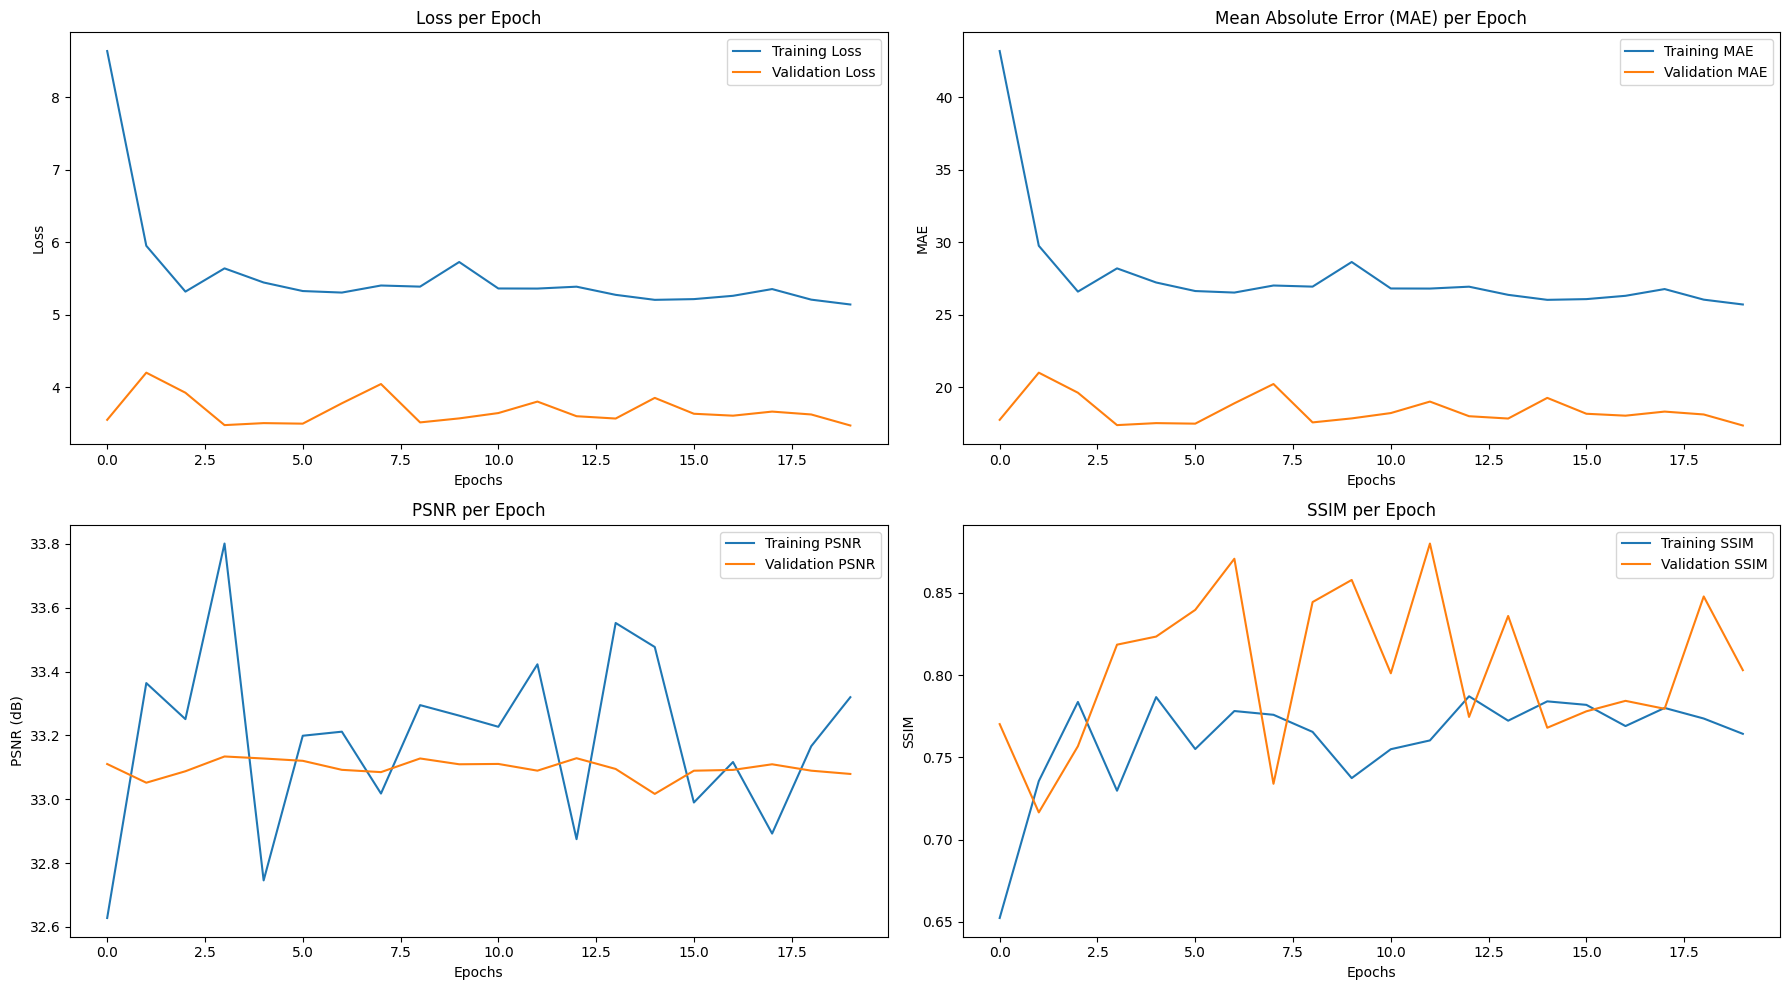

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plotting Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plotting MAE
plt.subplot(2, 2, 2)
plt.plot(train_mae_losses, label='Training MAE')
plt.plot(val_mae_losses, label='Validation MAE')
plt.title('Mean Absolute Error (MAE) per Epoch')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()

# Plotting PSNR
plt.subplot(2, 2, 3)
plt.plot(train_psnrs, label='Training PSNR')
plt.plot(val_psnrs, label='Validation PSNR')
plt.title('PSNR per Epoch')
plt.ylabel('PSNR (dB)')
plt.xlabel('Epochs')
plt.legend()

# Plotting SSIM
plt.subplot(2, 2, 4)
plt.plot(train_ssims, label='Training SSIM')
plt.plot(val_ssims, label='Validation SSIM')
plt.title('SSIM per Epoch')
plt.ylabel('SSIM')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


/tmp/ipykernel_30/1007136360.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('./crowd_counting.pth'))


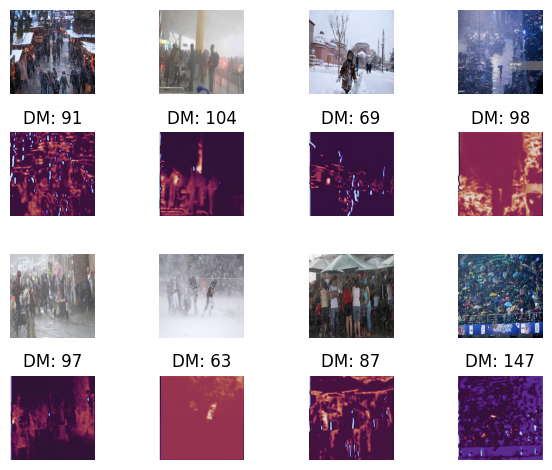

   40    13     6   281    38    46    21   260


In [29]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
# Get some random validation images
dataiter = iter(val_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

# Test Phase

In [30]:
import torch
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim

best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))

test_loss_acc = 0.0
test_psnr_acc = 0.0
test_ssim_acc = 0.0

criterion = nn.L1Loss()

with torch.inference_mode():
    for batch_img, batch_dmap, batch_gts in test_loader:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)

        # Forward pass
        logits = best_model(batch_img)
        pred_dmap = logits  # Predicted density map

        # Loss (MAE)
        loss = criterion(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        test_loss_acc += loss.item()

        # PSNR and SSIM
        for i in range(batch_dmap.size(0)):  # Iterate over batch
            pred_map = pred_dmap[i].unsqueeze(0)  # Predicted density map for one image
            true_map = batch_dmap[i].unsqueeze(0)  # Ground truth density map for one image

            # PSNR: Compare predicted and ground truth density maps
            psnr_val = psnr(pred_map, true_map)
            test_psnr_acc += psnr_val.item()

            # SSIM: Compare predicted and ground truth density maps
            ssim_val = ssim(pred_map, true_map)
            test_ssim_acc += ssim_val.item()

# Calculate averages
test_mae = test_loss_acc / len(test_loader.dataset)
test_psnr = test_psnr_acc / len(test_loader.dataset)
test_ssim = test_ssim_acc / len(test_loader.dataset)

# Print results
print('TEST: MAE: {:.3f} | PSNR: {:.3f} | SSIM: {:.3f}'.format(test_mae, test_psnr, test_ssim))


/tmp/ipykernel_30/2766220721.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('./crowd_counting.pth'))
/opt/conda/lib/python3.10/sit

TEST: MAE: 41.169 | PSNR: 22.401 | SSIM: 0.322


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


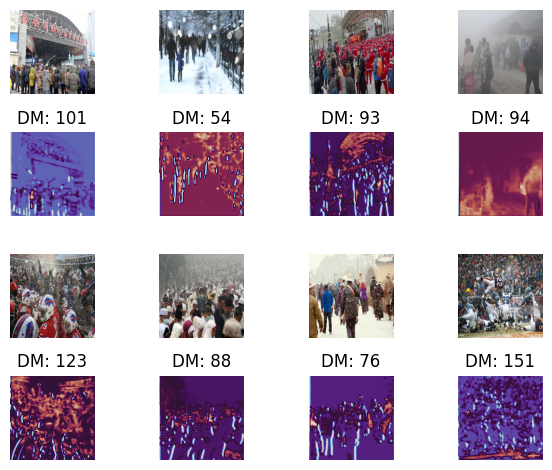

   32     9   263    12   237   284    19   178


In [31]:
# Get some random validation images
dataiter = iter(test_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

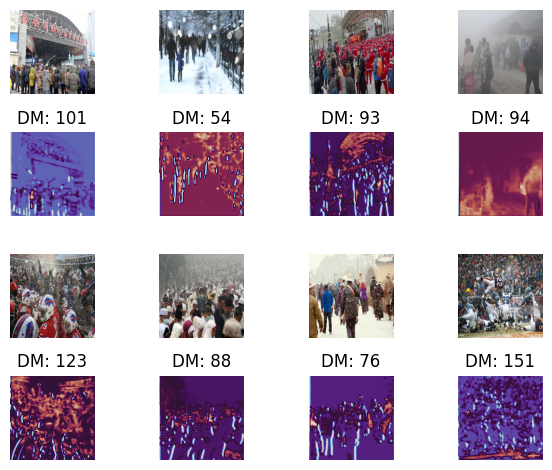

Image 1: Actual Count = 32, Predicted Count = 101
Image 2: Actual Count = 9, Predicted Count = 54
Image 3: Actual Count = 263, Predicted Count = 93
Image 4: Actual Count = 12, Predicted Count = 94
Image 5: Actual Count = 237, Predicted Count = 123
Image 6: Actual Count = 284, Predicted Count = 88
Image 7: Actual Count = 19, Predicted Count = 76
Image 8: Actual Count = 178, Predicted Count = 151


In [32]:
import torch

# Get some random validation images
dataiter = iter(test_loader)
ex_images, _, ex_gts = next(dataiter)

# Show images and predicted density map
pred_dms = best_model(ex_images.to(device))

# Plot the images and corresponding predicted density maps
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Calculate actual and predicted counts
actual_counts = [torch.sum(gt).item() for gt in ex_gts]
predicted_counts = [torch.sum(dm).item() for dm in pred_dms]

# Print actual and predicted counts
for i in range(len(actual_counts)):
    print(f"Image {i+1}: Actual Count = {actual_counts[i]}, Predicted Count = {round(predicted_counts[i])}")
